# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]
    
    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

    x_train = np.hstack((x_train, y_train))
    x_test = np.hstack((x_test, np.random.normal(size = (x_test.shape[0], y_train.shape[1]))))
    x_test_ = np.hstack((x_test_, np.random.normal(size = (x_test_.shape[0], y_train.shape[1]))))

    #x_test = np.hstack((x_test, y_test))
    
preprocess.x_train.std()

0.99186991653217405

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 124
    classes = 2
    hidden_encoder_dim = 124
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 124
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            self.x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
            self.y = tf.slice(self.x_hat, [0,input_dim-2], [-1,-1])

        with tf.variable_scope("Loss"):
            
            self.regularized_loss = tf.losses.mean_squared_error(self.x, self.x_hat) #tf.reduce_mean((BCE + KLD + softmax_loss) * lam)
            loss = tf.where(tf.is_nan(self.regularized_loss), 1e-2, self.regularized_loss)
            
            correct_prediction = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.y_, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate= self.lr #1e-2
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'test_score_20', 'time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0
    
    def train(epochs, net, h, f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_vae_only_nsl_kdd/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for lr in lrs:
                for epoch in range(1, (epochs+1)):
                    #print("Step {} | Training Loss:".format(epoch), end = " " )
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                      net.regularized_loss, 
                                                      ], #net.summary_op
                                                      feed_dict={net.x: x_train[i,:], 
                                                                 net.y_: y_train[i,:], 
                                                                 net.keep_prob:1, net.lr:lr})

                        train_batch()

                        count = 10
                        if((train_loss > 1e9 or np.isnan(train_loss) ) and epoch > 1 and count > 1):
                            print("Step {} | High Training Loss: {:.6f} ... Restoring Net".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_vae_only_nsl_kdd/hidden layers_{}_features count_{}'
                                                                         .format(epochs,h,f)))
                            train_batch()
                            count -= 1

                        #summary_writer_train.add_summary(summary_str, epoch)
                        #if(train_loss > 1e9):

                        #print("{:.6f}".format(train_loss), end = ", " )

                    #print("")
                    valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], feed_dict={net.x: x_valid, 
                                                                         net.y_: y_valid, 
                                                                         net.keep_prob:1, net.lr:lr})


                    accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test, 
                                                                             net.y_: preprocess.y_test, 
                                                                             net.keep_prob:1, net.lr:lr})
                    accuracy_, test_loss_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                                                           net.pred, 
                                                                                           net.actual, net.y], 
                                                                                          feed_dict={net.x: preprocess.x_test_, 
                                                                                                     net.y_: preprocess.y_test_, 
                                                                                                     net.keep_prob:1, net.lr:lr})
                    #print("*************** \n")
                    print("Step {} | Training Loss: {:.6f} | Test Loss: {:6f} | Test Accuracy: {:.6f}, {:.6f}".format(epoch, train_loss, test_loss, accuracy, accuracy_))
                    #print("*************** \n")
                    #print("Accuracy on Test data: {}".format(accuracy))


                    if accuracy > Train.best_acc_global:
                        Train.best_acc_global = accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        Train.pred_value_ = pred_value_
                        Train.actual_value_ = actual_value_
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:

                        #net.saver.save(sess, "dataset/tf_vae_only_nsl_kdd_hidden layers_{}_features count_{}".format(epochs,h,f))
                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
                        #curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
                        #Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})

                        Train.best_acc = accuracy
                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_vae_only_nsl_kdd/hidden layers_{}_features count_{}/model"
                                       .format(epochs,h,f), 
                                       global_step = epoch, 
                                       write_meta_graph=False)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                        Train.predictions.update({"{}_{}_{}".format(epochs*len(lrs),f,h):
                                                  (curr_pred, 
                                                   Train.result(epochs*len(lrs), f, h,valid_accuracy, accuracy, accuracy_, time.perf_counter() - start_time))})

            

In [ ]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]



    def start_training():

        global df_results
        global past_scores
        
        Train.predictions = {}
        Train.results = []
        
        features_arr = [4, 8, 32, 122]
        hidden_layers_arr = [3, 5]

        epochs = [15]
        lrs = [1e-2, 1e-2, 1e-3]

        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)

        dict1 = {}
        dict2 = []
        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)
            
        Train.predictions = dict1
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)
        temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        if not os.path.isfile('dataset/tf_vae_only_nsl_kdd_all.pkl'):
            past_scores = temp
        else:
            past_scores = pd.read_pickle("dataset/tf_vae_only_nsl_kdd_all.pkl")

        past_scores.append(temp).to_pickle("dataset/tf_vae_only_nsl_kdd_all.pkl")

        

In [ ]:
%%timeit -r 10

Hyperparameters.start_training()

Current Layer Attributes - epochs:15 hidden layers:3 features count:4
Step 1 | Training Loss: 0.562561 | Test Loss: 1.521995 | Test Accuracy: 0.775639, 0.576456
Step 2 | Training Loss: 0.271542 | Test Loss: 1.557155 | Test Accuracy: 0.761178, 0.583460
Step 3 | Training Loss: 0.224210 | Test Loss: 1.417905 | Test Accuracy: 0.773421, 0.575359
Step 4 | Training Loss: 0.224439 | Test Loss: 1.423599 | Test Accuracy: 0.777324, 0.594852
Step 5 | Training Loss: 0.210501 | Test Loss: 1.404875 | Test Accuracy: 0.779143, 0.601435
Step 6 | Training Loss: 0.225730 | Test Loss: 1.329915 | Test Accuracy: 0.738423, 0.575274
Step 7 | Training Loss: 0.698548 | Test Loss: 1.588156 | Test Accuracy: 0.775240, 0.705401
Step 8 | Training Loss: 0.623766 | Test Loss: 1.518320 | Test Accuracy: 0.782603, 0.626414
Step 9 | Training Loss: 0.537258 | Test Loss: 1.557600 | Test Accuracy: 0.792406, 0.653249
Step 10 | Training Loss: 0.541207 | Test Loss: 1.582321 | Test Accuracy: 0.784289, 0.604473
Step 11 | Training 

Step 15 | Training Loss: 1.194500 | Test Loss: 1.526101 | Test Accuracy: 0.791341, 0.624304
Current Layer Attributes - epochs:15 hidden layers:3 features count:32
Step 1 | Training Loss: 0.318412 | Test Loss: 1.622646 | Test Accuracy: 0.762376, 0.554093
Step 2 | Training Loss: 0.395392 | Test Loss: 1.498313 | Test Accuracy: 0.778788, 0.580253
Step 3 | Training Loss: 0.285594 | Test Loss: 1.458793 | Test Accuracy: 0.766057, 0.562110
Step 4 | Training Loss: 0.249801 | Test Loss: 1.792874 | Test Accuracy: 0.766146, 0.563713
Step 5 | Training Loss: 0.302665 | Test Loss: 1.625777 | Test Accuracy: 0.822259, 0.668270
Step 6 | Training Loss: 2.063657 | Test Loss: 1.448510 | Test Accuracy: 0.801854, 0.648861
Step 7 | Training Loss: 0.259562 | Test Loss: 1.664472 | Test Accuracy: 0.756033, 0.548945
Step 8 | Training Loss: 0.274847 | Test Loss: 1.613848 | Test Accuracy: 0.751641, 0.544810
Step 9 | Training Loss: 0.278545 | Test Loss: 1.683072 | Test Accuracy: 0.749556, 0.544219
Step 10 | Training

Step 12 | Training Loss: 0.841551 | Test Loss: 1.983122 | Test Accuracy: 0.430758, 0.181603
Step 13 | Training Loss: 1.261130 | Test Loss: 1.983482 | Test Accuracy: 0.430758, 0.181603
Step 14 | Training Loss: 0.898517 | Test Loss: 1.983454 | Test Accuracy: 0.430758, 0.181603
Step 15 | Training Loss: 0.863176 | Test Loss: 1.983161 | Test Accuracy: 0.430758, 0.181603
Current Layer Attributes - epochs:15 hidden layers:5 features count:4
Step 1 | Training Loss: 0.600334 | Test Loss: 1.799939 | Test Accuracy: 0.781361, 0.584810
Step 2 | Training Loss: 3.525110 | Test Loss: 1.755318 | Test Accuracy: 0.789567, 0.601857
Step 3 | Training Loss: 0.395413 | Test Loss: 1.650207 | Test Accuracy: 0.760468, 0.549030
Step 4 | Training Loss: 0.514076 | Test Loss: 1.711215 | Test Accuracy: 0.773377, 0.577722
Step 5 | Training Loss: 0.533297 | Test Loss: 1.727388 | Test Accuracy: 0.827449, 0.673840
Step 6 | Training Loss: 0.714420 | Test Loss: 1.950283 | Test Accuracy: 0.596301, 0.407764
Step 7 | Trainin

Step 9 | Training Loss: 0.883237 | Test Loss: 1.983332 | Test Accuracy: 0.430758, 0.181603
Step 10 | Training Loss: 0.786869 | Test Loss: 1.983344 | Test Accuracy: 0.430758, 0.181603
Step 11 | Training Loss: 1.009392 | Test Loss: 1.982831 | Test Accuracy: 0.430758, 0.181603
Step 12 | Training Loss: 0.923882 | Test Loss: 1.983832 | Test Accuracy: 0.430758, 0.181603
Step 13 | Training Loss: 0.836946 | Test Loss: 1.983453 | Test Accuracy: 0.430758, 0.181603
Step 14 | Training Loss: 0.916563 | Test Loss: 1.983188 | Test Accuracy: 0.430758, 0.181603
Step 15 | Training Loss: 1.216382 | Test Loss: 1.983188 | Test Accuracy: 0.430758, 0.181603
Current Layer Attributes - epochs:15 hidden layers:5 features count:32
Step 1 | Training Loss: 0.519347 | Test Loss: 1.770489 | Test Accuracy: 0.785575, 0.594093
Step 2 | Training Loss: 1.196941 | Test Loss: 1.738161 | Test Accuracy: 0.778877, 0.581350
Step 3 | Training Loss: 0.729592 | Test Loss: 1.671331 | Test Accuracy: 0.847853, 0.719156
Step 4 | Trai

Step 15 | Training Loss: 0.672697 | Test Loss: 1.983762 | Test Accuracy: 0.430758, 0.181603
Step 1 | Training Loss: 0.890124 | Test Loss: 1.983713 | Test Accuracy: 0.430758, 0.181603
Step 2 | Training Loss: 1.269494 | Test Loss: 1.983126 | Test Accuracy: 0.430758, 0.181603
Step 3 | Training Loss: 0.867887 | Test Loss: 1.983235 | Test Accuracy: 0.430758, 0.181603
Step 4 | Training Loss: 0.984206 | Test Loss: 1.983479 | Test Accuracy: 0.430758, 0.181603
Step 5 | Training Loss: 1.840717 | Test Loss: 1.983358 | Test Accuracy: 0.430758, 0.181603
Step 6 | Training Loss: 0.873374 | Test Loss: 1.983663 | Test Accuracy: 0.430758, 0.181603
Step 7 | Training Loss: 2.408365 | Test Loss: 1.983301 | Test Accuracy: 0.430758, 0.181603
Step 8 | Training Loss: 1.204813 | Test Loss: 1.983472 | Test Accuracy: 0.430758, 0.181603
Step 9 | Training Loss: 1.475158 | Test Loss: 1.983222 | Test Accuracy: 0.430758, 0.181603
Step 10 | Training Loss: 1.646057 | Test Loss: 1.983531 | Test Accuracy: 0.430758, 0.1816

Step 14 | Training Loss: 0.213732 | Test Loss: 1.571317 | Test Accuracy: 0.745653, 0.537975
Step 15 | Training Loss: 0.309826 | Test Loss: 1.570100 | Test Accuracy: 0.760601, 0.560506
Step 1 | Training Loss: 0.257198 | Test Loss: 1.550643 | Test Accuracy: 0.755944, 0.564473
Step 2 | Training Loss: 0.193615 | Test Loss: 1.541667 | Test Accuracy: 0.759980, 0.568270
Step 3 | Training Loss: 0.305623 | Test Loss: 1.546311 | Test Accuracy: 0.759359, 0.566498
Step 4 | Training Loss: 0.392711 | Test Loss: 1.540966 | Test Accuracy: 0.760779, 0.565063
Step 5 | Training Loss: 0.272967 | Test Loss: 1.550301 | Test Accuracy: 0.761267, 0.566160
Step 6 | Training Loss: 0.134844 | Test Loss: 1.543297 | Test Accuracy: 0.762287, 0.565992
Step 7 | Training Loss: 0.294326 | Test Loss: 1.547783 | Test Accuracy: 0.760823, 0.563966
Step 8 | Training Loss: 0.276805 | Test Loss: 1.552970 | Test Accuracy: 0.762331, 0.563376
Step 9 | Training Loss: 1.073683 | Test Loss: 1.553764 | Test Accuracy: 0.762952, 0.5654

Step 1 | Training Loss: 0.924790 | Test Loss: 1.943524 | Test Accuracy: 0.840578, 0.736540
Step 2 | Training Loss: 0.985566 | Test Loss: 1.941784 | Test Accuracy: 0.838316, 0.733249
Step 3 | Training Loss: 0.700943 | Test Loss: 1.941278 | Test Accuracy: 0.837562, 0.731392
Step 4 | Training Loss: 0.962682 | Test Loss: 2.005526 | Test Accuracy: 0.569242, 0.818397
Step 5 | Training Loss: 0.805124 | Test Loss: 1.985931 | Test Accuracy: 0.569242, 0.818397
Step 6 | Training Loss: 1.041684 | Test Loss: 1.983632 | Test Accuracy: 0.430758, 0.181603
Step 7 | Training Loss: 1.185073 | Test Loss: 1.983330 | Test Accuracy: 0.430758, 0.181603
Step 8 | Training Loss: 1.783865 | Test Loss: 1.983359 | Test Accuracy: 0.430758, 0.181603
Step 9 | Training Loss: 1.234734 | Test Loss: 1.983357 | Test Accuracy: 0.430758, 0.181603
Step 10 | Training Loss: 1.309232 | Test Loss: 1.983292 | Test Accuracy: 0.430758, 0.181603
Step 11 | Training Loss: 1.033287 | Test Loss: 1.983447 | Test Accuracy: 0.430758, 0.1816

Step 15 | Training Loss: 0.969238 | Test Loss: 1.983380 | Test Accuracy: 0.430758, 0.181603
Step 1 | Training Loss: 0.901083 | Test Loss: 1.983438 | Test Accuracy: 0.430758, 0.181603
Step 2 | Training Loss: 0.756218 | Test Loss: 1.982778 | Test Accuracy: 0.430758, 0.181603
Step 3 | Training Loss: 0.837450 | Test Loss: 1.983212 | Test Accuracy: 0.430758, 0.181603
Step 4 | Training Loss: 0.864568 | Test Loss: 1.983285 | Test Accuracy: 0.430758, 0.181603
Step 5 | Training Loss: 0.916609 | Test Loss: 1.983688 | Test Accuracy: 0.430758, 0.181603
Step 6 | Training Loss: 1.004742 | Test Loss: 1.983824 | Test Accuracy: 0.430758, 0.181603
Step 7 | Training Loss: 0.786203 | Test Loss: 1.984081 | Test Accuracy: 0.430758, 0.181603
Step 8 | Training Loss: 0.743884 | Test Loss: 1.984292 | Test Accuracy: 0.430758, 0.181603
Step 9 | Training Loss: 0.865998 | Test Loss: 1.982978 | Test Accuracy: 0.430758, 0.181603
Step 10 | Training Loss: 1.055945 | Test Loss: 1.983711 | Test Accuracy: 0.430758, 0.1816

Step 11 | Training Loss: 0.867166 | Test Loss: 1.984685 | Test Accuracy: 0.430758, 0.181603
Step 12 | Training Loss: 0.953868 | Test Loss: 1.985292 | Test Accuracy: 0.430758, 0.181603
Step 13 | Training Loss: 0.896247 | Test Loss: 1.983552 | Test Accuracy: 0.430758, 0.181603
Step 14 | Training Loss: 0.800041 | Test Loss: 1.981779 | Test Accuracy: 0.430758, 0.181603
Step 15 | Training Loss: 0.913718 | Test Loss: 1.983483 | Test Accuracy: 0.430758, 0.181603
Step 1 | Training Loss: 2.849828 | Test Loss: 1.983783 | Test Accuracy: 0.430758, 0.181603
Step 2 | Training Loss: 0.777381 | Test Loss: 1.982598 | Test Accuracy: 0.430758, 0.181603
Step 3 | Training Loss: 0.926121 | Test Loss: 1.983574 | Test Accuracy: 0.430758, 0.181603
Step 4 | Training Loss: 0.777689 | Test Loss: 1.983742 | Test Accuracy: 0.430758, 0.181603
Step 5 | Training Loss: 0.868612 | Test Loss: 1.983290 | Test Accuracy: 0.430758, 0.181603
Step 6 | Training Loss: 0.823952 | Test Loss: 1.984229 | Test Accuracy: 0.430758, 0.1

Step 10 | Training Loss: 0.219920 | Test Loss: 1.514323 | Test Accuracy: 0.658135, 0.616371
Step 11 | Training Loss: 0.245480 | Test Loss: 1.517212 | Test Accuracy: 0.658268, 0.595865
Step 12 | Training Loss: 0.217469 | Test Loss: 1.525393 | Test Accuracy: 0.663325, 0.622785
Step 13 | Training Loss: 0.973183 | Test Loss: 1.515436 | Test Accuracy: 0.653522, 0.604641
Step 14 | Training Loss: 0.152101 | Test Loss: 1.513426 | Test Accuracy: 0.661906, 0.625316
Step 15 | Training Loss: 0.319219 | Test Loss: 1.505149 | Test Accuracy: 0.664567, 0.616371
Step 1 | Training Loss: 0.282647 | Test Loss: 1.511389 | Test Accuracy: 0.670511, 0.621519
Step 2 | Training Loss: 0.292809 | Test Loss: 1.517202 | Test Accuracy: 0.704933, 0.645907
Step 3 | Training Loss: 0.186260 | Test Loss: 1.547464 | Test Accuracy: 0.644562, 0.604051
Step 4 | Training Loss: 0.617283 | Test Loss: 1.683421 | Test Accuracy: 0.725115, 0.720591
Step 5 | Training Loss: 0.367769 | Test Loss: 1.732457 | Test Accuracy: 0.716687, 0.

Step 1 | Training Loss: 0.320015 | Test Loss: 1.657338 | Test Accuracy: 0.792495, 0.610464
Step 2 | Training Loss: 1.146518 | Test Loss: 1.514304 | Test Accuracy: 0.779853, 0.583122
Step 3 | Training Loss: 0.364607 | Test Loss: 1.483250 | Test Accuracy: 0.796753, 0.617806
Step 4 | Training Loss: 0.542813 | Test Loss: 1.442532 | Test Accuracy: 0.769784, 0.573587
Step 5 | Training Loss: 0.193187 | Test Loss: 1.432256 | Test Accuracy: 0.779409, 0.643797
Step 6 | Training Loss: 0.570827 | Test Loss: 1.486250 | Test Accuracy: 0.782071, 0.655612
Step 7 | Training Loss: 0.320897 | Test Loss: 1.484681 | Test Accuracy: 0.749512, 0.638228
Step 8 | Training Loss: 0.278487 | Test Loss: 1.461334 | Test Accuracy: 0.740153, 0.616118
Step 9 | Training Loss: 0.256896 | Test Loss: 1.483877 | Test Accuracy: 0.699122, 0.577637
Step 10 | Training Loss: 0.769236 | Test Loss: 1.471108 | Test Accuracy: 0.687988, 0.586751
Step 11 | Training Loss: 0.342511 | Test Loss: 1.461600 | Test Accuracy: 0.735096, 0.5967

Step 15 | Training Loss: 0.758718 | Test Loss: 1.912976 | Test Accuracy: 0.677741, 0.476624
Current Layer Attributes - epochs:15 hidden layers:5 features count:8
Step 1 | Training Loss: 0.538962 | Test Loss: 1.754328 | Test Accuracy: 0.757142, 0.538903
Step 2 | Training Loss: 0.707729 | Test Loss: 1.658592 | Test Accuracy: 0.759936, 0.548017
Step 3 | Training Loss: 0.582584 | Test Loss: 1.533261 | Test Accuracy: 0.772800, 0.576203
Step 4 | Training Loss: 1.276193 | Test Loss: 1.609802 | Test Accuracy: 0.823767, 0.673165
Step 5 | Training Loss: 0.743450 | Test Loss: 1.567995 | Test Accuracy: 0.776836, 0.590717
Step 6 | Training Loss: 0.534519 | Test Loss: 1.539066 | Test Accuracy: 0.812988, 0.656709
Step 7 | Training Loss: 0.422093 | Test Loss: 1.552933 | Test Accuracy: 0.772489, 0.574937
Step 8 | Training Loss: 0.551977 | Test Loss: 1.611669 | Test Accuracy: 0.724361, 0.488861
Step 9 | Training Loss: 0.733759 | Test Loss: 1.740046 | Test Accuracy: 0.827404, 0.685907
Step 10 | Training 

Step 14 | Training Loss: 0.748224 | Test Loss: 1.983670 | Test Accuracy: 0.430758, 0.181603
Step 15 | Training Loss: 0.909746 | Test Loss: 1.983335 | Test Accuracy: 0.430758, 0.181603
Current Layer Attributes - epochs:15 hidden layers:5 features count:122
Step 1 | Training Loss: 0.668992 | Test Loss: 1.783431 | Test Accuracy: 0.782736, 0.589789
Step 2 | Training Loss: 0.716779 | Test Loss: 1.783601 | Test Accuracy: 0.792051, 0.607089
Step 3 | Training Loss: 0.699790 | Test Loss: 1.772811 | Test Accuracy: 0.795467, 0.619156
Step 4 | Training Loss: 1.091416 | Test Loss: 1.941126 | Test Accuracy: 0.459856, 0.234684
Step 5 | Training Loss: 0.909130 | Test Loss: 1.941607 | Test Accuracy: 0.459901, 0.234768
Step 6 | Training Loss: 1.010164 | Test Loss: 1.940232 | Test Accuracy: 0.459768, 0.234177
Step 7 | Training Loss: 0.770013 | Test Loss: 1.941621 | Test Accuracy: 0.459546, 0.233418
Step 8 | Training Loss: 1.048152 | Test Loss: 1.941212 | Test Accuracy: 0.459590, 0.233418
Step 9 | Trainin

Step 13 | Training Loss: 0.240415 | Test Loss: 1.487222 | Test Accuracy: 0.737757, 0.576118
Step 14 | Training Loss: 0.136026 | Test Loss: 1.485444 | Test Accuracy: 0.733588, 0.574262
Step 15 | Training Loss: 0.116900 | Test Loss: 1.484847 | Test Accuracy: 0.737802, 0.577384
Current Layer Attributes - epochs:15 hidden layers:3 features count:8
Step 1 | Training Loss: 0.329958 | Test Loss: 1.442713 | Test Accuracy: 0.779010, 0.584979
Step 2 | Training Loss: 0.293645 | Test Loss: 1.374751 | Test Accuracy: 0.771203, 0.568354
Step 3 | Training Loss: 0.232298 | Test Loss: 1.340091 | Test Accuracy: 0.767566, 0.561772
Step 4 | Training Loss: 0.603246 | Test Loss: 1.573051 | Test Accuracy: 0.787127, 0.602954
Step 5 | Training Loss: 0.461602 | Test Loss: 1.744793 | Test Accuracy: 0.723918, 0.734177
Step 6 | Training Loss: 2.255313 | Test Loss: 1.588145 | Test Accuracy: 0.669668, 0.649114
Step 7 | Training Loss: 0.222407 | Test Loss: 1.493935 | Test Accuracy: 0.743258, 0.674515
Step 8 | Training

Step 10 | Training Loss: 0.522534 | Test Loss: 1.732053 | Test Accuracy: 0.776393, 0.658481
Step 11 | Training Loss: 0.806883 | Test Loss: 1.740123 | Test Accuracy: 0.776526, 0.657637
Step 12 | Training Loss: 1.155574 | Test Loss: 1.738173 | Test Accuracy: 0.777812, 0.661350
Step 13 | Training Loss: 0.401491 | Test Loss: 1.739881 | Test Accuracy: 0.777014, 0.660844
Step 14 | Training Loss: 0.522673 | Test Loss: 1.738855 | Test Accuracy: 0.777058, 0.658397
Step 15 | Training Loss: 0.598548 | Test Loss: 1.738620 | Test Accuracy: 0.775949, 0.658397
Current Layer Attributes - epochs:15 hidden layers:3 features count:122
Step 1 | Training Loss: 0.646134 | Test Loss: 1.823809 | Test Accuracy: 0.797241, 0.617975
Step 2 | Training Loss: 0.554846 | Test Loss: 1.818756 | Test Accuracy: 0.776570, 0.580422
Step 3 | Training Loss: 1.544622 | Test Loss: 1.816554 | Test Accuracy: 0.775727, 0.578650
Step 4 | Training Loss: 0.641296 | Test Loss: 1.815203 | Test Accuracy: 0.767433, 0.563291
Step 5 | Tra

Step 3 | Training Loss: 0.846675 | Test Loss: 1.983536 | Test Accuracy: 0.430758, 0.181603
Step 4 | Training Loss: 0.831009 | Test Loss: 1.983758 | Test Accuracy: 0.430758, 0.181603
Step 5 | Training Loss: 1.007589 | Test Loss: 1.983125 | Test Accuracy: 0.430758, 0.181603
Step 6 | Training Loss: 0.962678 | Test Loss: 1.983397 | Test Accuracy: 0.430758, 0.181603
Step 7 | Training Loss: 0.740083 | Test Loss: 1.983072 | Test Accuracy: 0.430758, 0.181603
Step 8 | Training Loss: 0.944134 | Test Loss: 1.983568 | Test Accuracy: 0.430758, 0.181603
Step 9 | Training Loss: 0.962947 | Test Loss: 1.982919 | Test Accuracy: 0.430758, 0.181603
Step 10 | Training Loss: 0.744825 | Test Loss: 1.983786 | Test Accuracy: 0.430758, 0.181603
Step 11 | Training Loss: 0.824832 | Test Loss: 1.983450 | Test Accuracy: 0.430758, 0.181603
Step 12 | Training Loss: 0.860274 | Test Loss: 1.982952 | Test Accuracy: 0.430758, 0.181603
Step 13 | Training Loss: 0.770405 | Test Loss: 1.983213 | Test Accuracy: 0.430758, 0.18

Step 2 | Training Loss: 1.032400 | Test Loss: 1.975213 | Test Accuracy: 0.430758, 0.181603
Step 3 | Training Loss: 0.736054 | Test Loss: 1.975460 | Test Accuracy: 0.430758, 0.181603
Step 4 | Training Loss: 0.724758 | Test Loss: 1.975558 | Test Accuracy: 0.430758, 0.181603
Step 5 | Training Loss: 0.974757 | Test Loss: 1.975314 | Test Accuracy: 0.430758, 0.181603
Step 6 | Training Loss: 0.898500 | Test Loss: 1.975486 | Test Accuracy: 0.430758, 0.181603
Step 7 | Training Loss: 0.821113 | Test Loss: 1.975634 | Test Accuracy: 0.430758, 0.181603
Step 8 | Training Loss: 1.412115 | Test Loss: 1.975456 | Test Accuracy: 0.430758, 0.181603
Step 9 | Training Loss: 0.791160 | Test Loss: 1.975926 | Test Accuracy: 0.430758, 0.181603
Step 10 | Training Loss: 1.025970 | Test Loss: 1.975883 | Test Accuracy: 0.430758, 0.181603
Step 11 | Training Loss: 0.840837 | Test Loss: 1.975683 | Test Accuracy: 0.430758, 0.181603
Step 12 | Training Loss: 1.096418 | Test Loss: 1.975840 | Test Accuracy: 0.430758, 0.181

Step 14 | Training Loss: 0.415315 | Test Loss: 1.825419 | Test Accuracy: 0.829578, 0.797806
Step 15 | Training Loss: 0.546677 | Test Loss: 1.813991 | Test Accuracy: 0.799858, 0.760338
Step 1 | Training Loss: 0.514846 | Test Loss: 1.794150 | Test Accuracy: 0.818222, 0.796540
Step 2 | Training Loss: 0.437502 | Test Loss: 1.790689 | Test Accuracy: 0.816492, 0.798059
Step 3 | Training Loss: 0.842600 | Test Loss: 1.791076 | Test Accuracy: 0.814674, 0.793671
Step 4 | Training Loss: 0.445213 | Test Loss: 1.790757 | Test Accuracy: 0.812855, 0.793333
Step 5 | Training Loss: 0.461606 | Test Loss: 1.790585 | Test Accuracy: 0.812855, 0.787679
Step 6 | Training Loss: 0.402175 | Test Loss: 1.784015 | Test Accuracy: 0.813875, 0.790380
Step 7 | Training Loss: 0.405405 | Test Loss: 1.782016 | Test Accuracy: 0.815827, 0.788692
Step 8 | Training Loss: 0.475610 | Test Loss: 1.784542 | Test Accuracy: 0.818932, 0.791730
Step 9 | Training Loss: 0.378435 | Test Loss: 1.777350 | Test Accuracy: 0.820307, 0.7875

Step 13 | Training Loss: 0.477008 | Test Loss: 1.789807 | Test Accuracy: 0.894828, 0.812827
Step 14 | Training Loss: 0.704902 | Test Loss: 1.819482 | Test Accuracy: 0.872072, 0.765654
Step 15 | Training Loss: 0.894826 | Test Loss: 1.814279 | Test Accuracy: 0.867193, 0.757553
Step 1 | Training Loss: 0.704630 | Test Loss: 1.813510 | Test Accuracy: 0.866306, 0.755527
Step 2 | Training Loss: 0.820523 | Test Loss: 1.813227 | Test Accuracy: 0.869855, 0.761013
Step 3 | Training Loss: 0.588156 | Test Loss: 1.812643 | Test Accuracy: 0.869544, 0.763460
Step 4 | Training Loss: 0.727893 | Test Loss: 1.812097 | Test Accuracy: 0.871097, 0.766920
Step 5 | Training Loss: 0.538144 | Test Loss: 1.811498 | Test Accuracy: 0.870076, 0.763291
Step 6 | Training Loss: 0.701527 | Test Loss: 1.811268 | Test Accuracy: 0.871407, 0.766582
Step 7 | Training Loss: 0.530465 | Test Loss: 1.811296 | Test Accuracy: 0.869855, 0.763122
Step 8 | Training Loss: 0.672046 | Test Loss: 1.810966 | Test Accuracy: 0.872472, 0.768

Step 12 | Training Loss: 0.712221 | Test Loss: 1.794986 | Test Accuracy: 0.782603, 0.590970
Step 13 | Training Loss: 0.753985 | Test Loss: 1.724198 | Test Accuracy: 0.781494, 0.590549
Step 14 | Training Loss: 0.868748 | Test Loss: 1.853841 | Test Accuracy: 0.806512, 0.823544
Step 15 | Training Loss: 0.687091 | Test Loss: 1.898507 | Test Accuracy: 0.858321, 0.826751
Step 1 | Training Loss: 0.788269 | Test Loss: 1.895982 | Test Accuracy: 0.857612, 0.827004
Step 2 | Training Loss: 0.717493 | Test Loss: 1.896376 | Test Accuracy: 0.857168, 0.826920
Step 3 | Training Loss: 0.696588 | Test Loss: 1.897370 | Test Accuracy: 0.855616, 0.827004
Step 4 | Training Loss: 0.700776 | Test Loss: 1.899637 | Test Accuracy: 0.848297, 0.825232
Step 5 | Training Loss: 2.471518 | Test Loss: 1.893752 | Test Accuracy: 0.869988, 0.829367
Step 6 | Training Loss: 0.918995 | Test Loss: 1.893803 | Test Accuracy: 0.872427, 0.831899
Step 7 | Training Loss: 0.883598 | Test Loss: 1.894736 | Test Accuracy: 0.865463, 0.83

Step 5 | Training Loss: 0.683322 | Test Loss: 1.976265 | Test Accuracy: 0.430758, 0.181603
Step 6 | Training Loss: 0.773310 | Test Loss: 1.977293 | Test Accuracy: 0.430758, 0.181603
Step 7 | Training Loss: 0.740695 | Test Loss: 1.975490 | Test Accuracy: 0.430758, 0.181603
Step 8 | Training Loss: 1.003627 | Test Loss: 1.976776 | Test Accuracy: 0.430758, 0.181603
Step 9 | Training Loss: 1.175445 | Test Loss: 1.976488 | Test Accuracy: 0.430758, 0.181603
Step 10 | Training Loss: 0.828508 | Test Loss: 1.976966 | Test Accuracy: 0.430758, 0.181603
Step 11 | Training Loss: 0.710658 | Test Loss: 1.976839 | Test Accuracy: 0.430758, 0.181603
Step 12 | Training Loss: 0.838346 | Test Loss: 1.976264 | Test Accuracy: 0.430758, 0.181603
Step 13 | Training Loss: 0.917815 | Test Loss: 1.975773 | Test Accuracy: 0.430758, 0.181603
Step 14 | Training Loss: 0.826804 | Test Loss: 1.975761 | Test Accuracy: 0.430758, 0.181603
Step 15 | Training Loss: 0.972928 | Test Loss: 1.975865 | Test Accuracy: 0.430802, 0.

Step 2 | Training Loss: 0.117566 | Test Loss: 1.486880 | Test Accuracy: 0.715268, 0.535612
Step 3 | Training Loss: 0.152000 | Test Loss: 1.728512 | Test Accuracy: 0.725248, 0.493755
Step 4 | Training Loss: 0.333182 | Test Loss: 1.763302 | Test Accuracy: 0.671842, 0.546751
Step 5 | Training Loss: 0.235085 | Test Loss: 1.754071 | Test Accuracy: 0.647489, 0.484641
Step 6 | Training Loss: 0.547697 | Test Loss: 1.566161 | Test Accuracy: 0.709768, 0.605654
Step 7 | Training Loss: 0.225605 | Test Loss: 1.539451 | Test Accuracy: 0.775151, 0.654599
Step 8 | Training Loss: 0.310167 | Test Loss: 1.832516 | Test Accuracy: 0.716199, 0.556371
Step 9 | Training Loss: 1.156962 | Test Loss: 1.677680 | Test Accuracy: 0.686435, 0.538481
Step 10 | Training Loss: 0.384457 | Test Loss: 2.117095 | Test Accuracy: 0.673971, 0.557721
Step 11 | Training Loss: 0.506401 | Test Loss: 1.732200 | Test Accuracy: 0.701029, 0.659325
Step 12 | Training Loss: 0.336336 | Test Loss: 1.636856 | Test Accuracy: 0.747605, 0.658

Step 12 | Training Loss: 0.829689 | Test Loss: 1.983722 | Test Accuracy: 0.430758, 0.181603
Step 13 | Training Loss: 0.965208 | Test Loss: 1.983357 | Test Accuracy: 0.430758, 0.181603
Step 14 | Training Loss: 2.670392 | Test Loss: 1.982870 | Test Accuracy: 0.430758, 0.181603
Step 15 | Training Loss: 0.708625 | Test Loss: 1.983295 | Test Accuracy: 0.430758, 0.181603
Step 1 | Training Loss: 0.779334 | Test Loss: 1.984291 | Test Accuracy: 0.430758, 0.181603
Step 2 | Training Loss: 0.799440 | Test Loss: 1.982750 | Test Accuracy: 0.430758, 0.181603
Step 3 | Training Loss: 0.900009 | Test Loss: 1.983575 | Test Accuracy: 0.430758, 0.181603
Step 4 | Training Loss: 0.711724 | Test Loss: 1.984626 | Test Accuracy: 0.430758, 0.181603
Step 5 | Training Loss: 0.828331 | Test Loss: 1.983362 | Test Accuracy: 0.430758, 0.181603
Step 6 | Training Loss: 0.851150 | Test Loss: 1.983994 | Test Accuracy: 0.430758, 0.181603
Step 7 | Training Loss: 1.023049 | Test Loss: 1.985070 | Test Accuracy: 0.430758, 0.18

Step 11 | Training Loss: 0.570231 | Test Loss: 1.748158 | Test Accuracy: 0.761622, 0.630042
Step 12 | Training Loss: 0.582333 | Test Loss: 1.832595 | Test Accuracy: 0.850293, 0.728354
Step 13 | Training Loss: 0.486608 | Test Loss: 1.779875 | Test Accuracy: 0.852599, 0.731646
Step 14 | Training Loss: 0.504678 | Test Loss: 1.747177 | Test Accuracy: 0.823944, 0.683038
Step 15 | Training Loss: 0.835888 | Test Loss: 1.746857 | Test Accuracy: 0.853353, 0.735106
Step 1 | Training Loss: 0.513254 | Test Loss: 1.791600 | Test Accuracy: 0.854551, 0.733586
Step 2 | Training Loss: 0.799740 | Test Loss: 1.944997 | Test Accuracy: 0.446904, 0.211561
Step 3 | Training Loss: 0.966046 | Test Loss: 1.953118 | Test Accuracy: 0.444908, 0.215443
Step 4 | Training Loss: 0.965377 | Test Loss: 1.948416 | Test Accuracy: 0.458437, 0.235359
Step 5 | Training Loss: 0.814606 | Test Loss: 1.944222 | Test Accuracy: 0.597454, 0.834937
Step 6 | Training Loss: 0.730359 | Test Loss: 1.939351 | Test Accuracy: 0.455554, 0.2

Step 8 | Training Loss: 0.525307 | Test Loss: 1.693710 | Test Accuracy: 0.826162, 0.686582
Step 9 | Training Loss: 0.940762 | Test Loss: 1.714838 | Test Accuracy: 0.814629, 0.657046
Step 10 | Training Loss: 0.478229 | Test Loss: 1.751251 | Test Accuracy: 0.777591, 0.603122
Step 11 | Training Loss: 0.623015 | Test Loss: 1.799959 | Test Accuracy: 0.812766, 0.656034
Step 12 | Training Loss: 0.701392 | Test Loss: 1.771969 | Test Accuracy: 0.792761, 0.612658
Step 13 | Training Loss: 0.493126 | Test Loss: 1.758096 | Test Accuracy: 0.846079, 0.715021
Step 14 | Training Loss: 0.564663 | Test Loss: 1.827502 | Test Accuracy: 0.778966, 0.589789
Step 15 | Training Loss: 0.878709 | Test Loss: 1.793518 | Test Accuracy: 0.802032, 0.635190
Step 1 | Training Loss: 0.558939 | Test Loss: 1.814318 | Test Accuracy: 0.766057, 0.567764
Step 2 | Training Loss: 0.921699 | Test Loss: 1.983716 | Test Accuracy: 0.430758, 0.181603
Step 3 | Training Loss: 0.841394 | Test Loss: 1.983996 | Test Accuracy: 0.430758, 0.

Step 7 | Training Loss: 0.099484 | Test Loss: 1.408750 | Test Accuracy: 0.806334, 0.637553
Step 8 | Training Loss: 0.150498 | Test Loss: 1.234257 | Test Accuracy: 0.719571, 0.684557
Step 9 | Training Loss: 0.124277 | Test Loss: 1.813668 | Test Accuracy: 0.773243, 0.590127
Step 10 | Training Loss: 0.118895 | Test Loss: 1.531993 | Test Accuracy: 0.733854, 0.586920
Step 11 | Training Loss: 0.068102 | Test Loss: 1.635950 | Test Accuracy: 0.758872, 0.547173
Step 12 | Training Loss: 0.059874 | Test Loss: 1.556708 | Test Accuracy: 0.786861, 0.602278
Step 13 | Training Loss: 0.090227 | Test Loss: 1.574419 | Test Accuracy: 0.753282, 0.535105
Step 14 | Training Loss: 0.129086 | Test Loss: 1.766412 | Test Accuracy: 0.779276, 0.586160
Step 15 | Training Loss: 0.180215 | Test Loss: 1.610824 | Test Accuracy: 0.768009, 0.573840
Step 1 | Training Loss: 0.206624 | Test Loss: 1.977719 | Test Accuracy: 0.752750, 0.536287
Step 2 | Training Loss: 0.825119 | Test Loss: 1.911254 | Test Accuracy: 0.756254, 0.

Step 6 | Training Loss: 0.331090 | Test Loss: 1.505720 | Test Accuracy: 0.727466, 0.596203
Step 7 | Training Loss: 0.376776 | Test Loss: 1.539810 | Test Accuracy: 0.833038, 0.698481
Step 8 | High Training Loss: 3179633180672.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd/hidden layers_15_features count_3/model-1
Step 8 | Training Loss: 0.666392 | Test Loss: 1.600524 | Test Accuracy: 0.786773, 0.597300
Step 9 | Training Loss: 0.414475 | Test Loss: 1.626799 | Test Accuracy: 0.785220, 0.592911
Step 10 | Training Loss: 0.352721 | Test Loss: 1.618991 | Test Accuracy: 0.816803, 0.690464
Step 11 | Training Loss: 0.349434 | Test Loss: 1.833312 | Test Accuracy: 0.784333, 0.717384
Step 12 | Training Loss: 0.214280 | Test Loss: 1.472163 | Test Accuracy: 0.705287, 0.613333
Step 13 | Training Loss: 0.385375 | Test Loss: 1.631814 | Test Accuracy: 0.789123, 0.601772
Step 14 | Training Loss: 0.331149 | Test Loss: 1.623147 | Test Accuracy: 0.768808, 0.564

Step 11 | Training Loss: 0.637157 | Test Loss: 1.795095 | Test Accuracy: 0.798616, 0.624219
Step 12 | Training Loss: 0.676185 | Test Loss: 1.795298 | Test Accuracy: 0.796975, 0.622616
Step 13 | Training Loss: 0.542329 | Test Loss: 1.794917 | Test Accuracy: 0.798971, 0.626582
Step 14 | Training Loss: 0.758644 | Test Loss: 1.793597 | Test Accuracy: 0.798927, 0.625485
Step 15 | Training Loss: 0.606227 | Test Loss: 1.793517 | Test Accuracy: 0.801987, 0.630802
Current Layer Attributes - epochs:15 hidden layers:5 features count:4
Step 1 | Training Loss: 0.910485 | Test Loss: 1.778491 | Test Accuracy: 0.810770, 0.644557
Step 2 | Training Loss: 0.498275 | Test Loss: 1.739577 | Test Accuracy: 0.786684, 0.595696
Step 3 | Training Loss: 0.772945 | Test Loss: 1.701606 | Test Accuracy: 0.772667, 0.577131
Step 4 | Training Loss: 0.668777 | Test Loss: 1.797339 | Test Accuracy: 0.810193, 0.653165
Step 5 | Training Loss: 0.655710 | Test Loss: 1.618333 | Test Accuracy: 0.732434, 0.584473
Step 6 | Traini

Step 10 | Training Loss: 0.669400 | Test Loss: 1.852865 | Test Accuracy: 0.790942, 0.698650
Step 11 | Training Loss: 0.980126 | Test Loss: 1.851940 | Test Accuracy: 0.789878, 0.696793
Step 12 | Training Loss: 0.743213 | Test Loss: 1.852020 | Test Accuracy: 0.790144, 0.697131
Step 13 | Training Loss: 0.684244 | Test Loss: 1.850513 | Test Accuracy: 0.788680, 0.695274
Step 14 | Training Loss: 0.650518 | Test Loss: 1.850154 | Test Accuracy: 0.789611, 0.695359
Step 15 | Training Loss: 1.499781 | Test Loss: 1.850160 | Test Accuracy: 0.789966, 0.694093
Current Layer Attributes - epochs:15 hidden layers:5 features count:32
Step 1 | Training Loss: 0.729320 | Test Loss: 1.800889 | Test Accuracy: 0.747826, 0.522869
Step 2 | Training Loss: 0.511175 | Test Loss: 1.756640 | Test Accuracy: 0.761932, 0.548608
Step 3 | Training Loss: 0.613447 | Test Loss: 1.771788 | Test Accuracy: 0.792761, 0.610802
Step 4 | Training Loss: 0.758882 | Test Loss: 1.957739 | Test Accuracy: 0.800390, 0.635949
Step 5 | Trai

Step 14 | Training Loss: 0.932948 | Test Loss: 1.983115 | Test Accuracy: 0.430758, 0.181603
Step 15 | Training Loss: 0.997102 | Test Loss: 1.983491 | Test Accuracy: 0.430758, 0.181603
Step 1 | Training Loss: 0.838370 | Test Loss: 1.983458 | Test Accuracy: 0.430758, 0.181603
Step 2 | Training Loss: 1.438473 | Test Loss: 1.983358 | Test Accuracy: 0.430758, 0.181603
Step 3 | Training Loss: 0.849855 | Test Loss: 1.983305 | Test Accuracy: 0.430758, 0.181603
Step 4 | Training Loss: 0.892170 | Test Loss: 1.983347 | Test Accuracy: 0.430758, 0.181603
Step 5 | Training Loss: 0.761903 | Test Loss: 1.983359 | Test Accuracy: 0.430758, 0.181603
Step 6 | Training Loss: 1.037480 | Test Loss: 1.983364 | Test Accuracy: 0.430758, 0.181603
Step 7 | Training Loss: 0.894580 | Test Loss: 1.983385 | Test Accuracy: 0.430758, 0.181603
Step 8 | Training Loss: 0.783599 | Test Loss: 1.983438 | Test Accuracy: 0.430758, 0.181603
Step 9 | Training Loss: 0.811550 | Test Loss: 1.983348 | Test Accuracy: 0.430758, 0.1816

Step 13 | Training Loss: 0.631674 | Test Loss: 2.140742 | Test Accuracy: 0.755012, 0.658903
Step 14 | Training Loss: 2.097678 | Test Loss: 1.795507 | Test Accuracy: 0.795733, 0.705148
Step 15 | Training Loss: 0.588768 | Test Loss: 1.808883 | Test Accuracy: 0.790898, 0.694515
Step 1 | Training Loss: 0.573031 | Test Loss: 1.810516 | Test Accuracy: 0.790720, 0.694430
Step 2 | Training Loss: 0.594483 | Test Loss: 1.805079 | Test Accuracy: 0.789833, 0.693586
Step 3 | Training Loss: 0.654789 | Test Loss: 1.805904 | Test Accuracy: 0.789523, 0.692911
Step 4 | Training Loss: 0.795421 | Test Loss: 1.806160 | Test Accuracy: 0.790632, 0.693840
Step 5 | Training Loss: 0.800848 | Test Loss: 1.805841 | Test Accuracy: 0.792273, 0.692911
Step 6 | Training Loss: 0.507305 | Test Loss: 1.805224 | Test Accuracy: 0.794757, 0.694262
Step 7 | Training Loss: 0.606288 | Test Loss: 1.805482 | Test Accuracy: 0.792805, 0.694177
Step 8 | Training Loss: 0.620637 | Test Loss: 1.804056 | Test Accuracy: 0.796043, 0.694

Step 12 | Training Loss: 0.741032 | Test Loss: 1.984084 | Test Accuracy: 0.430758, 0.181603
Step 13 | Training Loss: 0.886753 | Test Loss: 1.984065 | Test Accuracy: 0.430758, 0.181603
Step 14 | Training Loss: 1.157859 | Test Loss: 1.983356 | Test Accuracy: 0.430758, 0.181603
Step 15 | Training Loss: 1.110394 | Test Loss: 1.982698 | Test Accuracy: 0.430758, 0.181603
Step 1 | Training Loss: 2.754974 | Test Loss: 1.983240 | Test Accuracy: 0.430758, 0.181603
Step 2 | Training Loss: 0.835381 | Test Loss: 1.983279 | Test Accuracy: 0.430758, 0.181603
Step 3 | Training Loss: 1.059148 | Test Loss: 1.983376 | Test Accuracy: 0.430758, 0.181603
Step 4 | Training Loss: 0.879117 | Test Loss: 1.983122 | Test Accuracy: 0.430758, 0.181603
Step 5 | Training Loss: 1.061168 | Test Loss: 1.983298 | Test Accuracy: 0.430758, 0.181603
Step 6 | Training Loss: 0.698956 | Test Loss: 1.983205 | Test Accuracy: 0.430758, 0.181603
Step 7 | Training Loss: 0.744698 | Test Loss: 1.983401 | Test Accuracy: 0.430758, 0.18

Step 11 | Training Loss: 0.732463 | Test Loss: 1.943719 | Test Accuracy: 0.693400, 0.430802
Step 12 | Training Loss: 0.846058 | Test Loss: 1.938926 | Test Accuracy: 0.693400, 0.430802
Step 13 | Training Loss: 0.933705 | Test Loss: 1.938320 | Test Accuracy: 0.693400, 0.430802
Step 14 | Training Loss: 0.878147 | Test Loss: 1.938981 | Test Accuracy: 0.693400, 0.430802
Step 15 | Training Loss: 0.852485 | Test Loss: 1.940206 | Test Accuracy: 0.693400, 0.430802
Step 1 | Training Loss: 0.853159 | Test Loss: 1.939085 | Test Accuracy: 0.693400, 0.430802
Step 2 | Training Loss: 0.997965 | Test Loss: 1.938941 | Test Accuracy: 0.693400, 0.430802
Step 3 | Training Loss: 1.022452 | Test Loss: 1.938715 | Test Accuracy: 0.693400, 0.430802
Step 4 | Training Loss: 1.005084 | Test Loss: 1.939317 | Test Accuracy: 0.693400, 0.430802
Step 5 | Training Loss: 0.848770 | Test Loss: 1.938864 | Test Accuracy: 0.693400, 0.430802
Step 6 | Training Loss: 0.806904 | Test Loss: 1.938911 | Test Accuracy: 0.693400, 0.4

In [11]:
g = df_results.groupby(by=['no_of_features'])
idx = g['test_score'].transform(max) == df_results['test_score']
df_results[idx].sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
2,45,32,3,0.945626,0.873270,0.775190,92.474866
0,45,4,3,0.951183,0.856148,0.750295,92.310840
1,45,8,3,0.947928,0.854906,0.740844,25.245574
7,45,122,5,0.938720,0.815206,0.670802,109.704163


In [12]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
2,45,32,3,0.945626,0.873270,0.775190,92.474866
0,45,4,3,0.951183,0.856148,0.750295,92.310840
1,45,8,3,0.947928,0.854906,0.740844,25.245574
6,45,32,5,0.934275,0.819908,0.673418,54.706809
4,45,4,5,0.913161,0.817468,0.660338,81.455529
7,45,122,5,0.938720,0.815206,0.670802,109.704163
5,45,8,5,0.958485,0.799060,0.623122,22.302811
3,45,122,3,0.535958,0.430758,0.181603,6.090720


In [13]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_only_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_vae_only_nsl_kdd_scores.pkl")

AttributeError: 'tuple' object has no attribute 'shape'

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.9445  0.0555]
 [ 0.1376  0.8624]]


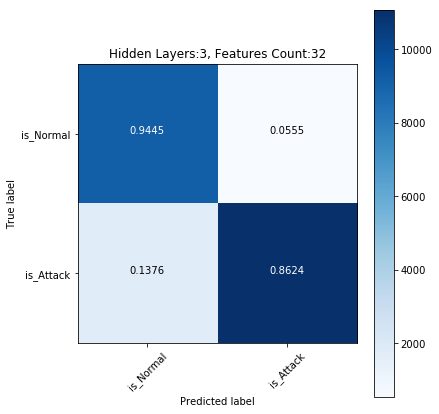

In [15]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)

Normalized confusion matrix
[[ 0.8146  0.1854]
 [ 0.1796  0.8204]]


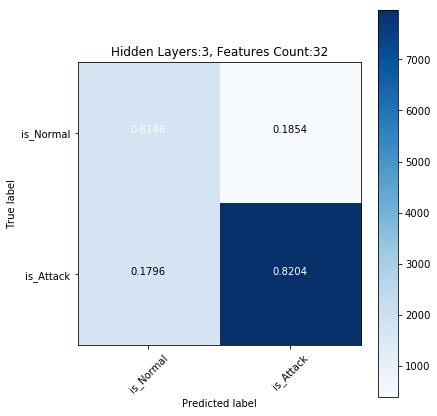

In [16]:
plot(actual_value = Train.actual_value_, pred_value = Train.pred_value_)

In [17]:
past_scores

,,epoch,train_score,test_score,test_score_20,time_taken
no_of_features,hidden_layers,,,,,
1,1,45,0.928639,0.774973,0.689114,16.006346
8,1,45,0.948801,0.810238,0.676034,5.418028
32,1,45,0.952215,0.811391,0.649367,6.201481
122,1,45,0.533339,0.430758,0.181603,4.315096
1,3,45,0.933243,0.833304,0.694684,33.188258
8,3,45,0.961343,0.790188,0.609198,5.809257
32,3,45,0.959914,0.860140,0.749705,171.153311
122,3,45,0.927449,0.809572,0.642869,51.082118
1,5,45,0.865693,0.854152,0.740759,374.074049


In [18]:
pgb = past_scores.groupby(by=['no_of_features', 'hidden_layers'])
pgb.mean()

epoch  train_score  test_score  \
no_of_features hidden_layers                                       
1              1              45.000000     0.928639    0.774973   
               3              45.000000     0.933243    0.833304   
               5              45.000000     0.865693    0.854152   
4              3              45.000000     0.943789    0.831840   
               5              45.000000     0.916132    0.847251   
8              1              45.000000     0.948801    0.810238   
               3              24.444444     0.954869    0.831015   
               5              25.000000     0.923625    0.860185   
32             1              45.000000     0.952215    0.811391   
               3              25.600000     0.938908    0.845727   
               5              25.454545     0.927636    0.843718   
122            1              45.000000     0.533339    0.430758   
               3              25.217391     0.843564    0.755545   
               5              25.714286     0.924421    0.843276   

                              test_score_20  time_taken  
no_of_features hidden_layers                             
1              1                   0.689114   16.006346  
               3                   0.694684   33.188258  
               5                   0.740759  374.074049  
4              3                   0.718119   86.782945  
               5                   0.727257  126.259372  
8              1                   0.676034    5.418028  
               3                   0.699778   81.534432  
               5                   0.761980  102.170062  
32             1                   0.649367    6.201481  
               3                   0.734046   86.881006  
               5                   0.726160   87.178110  
122            1                   0.181603    4.315096  
               3                   0.598294   71.647871  
               5                   0.712047   38.452549

In [19]:
pgb.std()

epoch  train_score  test_score  \
no_of_features hidden_layers                                       
1              1               0.000000     0.000000    0.000000   
               3               0.000000     0.000000    0.000000   
               5               0.000000     0.000000    0.000000   
4              3               0.000000     0.011787    0.030105   
               5               0.000000     0.027186    0.024903   
8              1               0.000000     0.000000    0.000000   
               3              20.159619     0.012021    0.027905   
               5              21.366369     0.027935    0.024676   
32             1               0.000000     0.000000    0.000000   
               3              21.130547     0.033205    0.029468   
               5              22.302524     0.048643    0.024984   
122            1               0.000000     0.000000    0.000000   
               3              21.819417     0.149651    0.156931   
               5              22.819165     0.017728    0.029547   

                              test_score_20  time_taken  
no_of_features hidden_layers                             
1              1                   0.000000    0.000000  
               3                   0.000000    0.000000  
               5                   0.000000    0.000000  
4              3                   0.064816   64.825826  
               5                   0.062564  104.635137  
8              1                   0.000000    0.000000  
               3                   0.058516   67.677556  
               5                   0.049033   61.004967  
32             1                   0.000000    0.000000  
               3                   0.071183   78.186106  
               5                   0.054157   73.186361  
122            1                   0.000000    0.000000  
               3                   0.211851   61.487792  
               5                   0.059100   26.088546